In [11]:
import numpy as np
import torch
from lib.models import iVAE
from lib.iFlow import iFlow
from lib.metrics import mean_corr_coef as mcc
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from lib.data import DataLoaderGPU

In [12]:
def correlation_coefficients(x, y, method='pearson'):
    """
    A numpy implementation of the mean correlation coefficient metric.

    :param x: numpy.ndarray
    :param y: numpy.ndarray
    :param method: str, optional
            The method used to compute the correlation coefficients.
                The options are 'pearson' and 'spearman'
                'pearson':
                    use Pearson's correlation coefficient
                'spearman':
                    use Spearman's nonparametric rank correlation coefficient
    :return: float
    """
    d = x.shape[1]
    if method == 'pearson':
        cc = np.corrcoef(x, y, rowvar=False)[:d, d:]
    elif method == 'spearman':
        cc = spearmanr(x, y)[0][:d, d:]
    else:
        raise ValueError('not a valid method: {}'.format(method))
    cc_matrix = np.abs(cc)

    corr_coefs = cc_matrix[linear_sum_assignment(-1 * cc_matrix)] #.mean()
    return corr_coefs, cc_matrix

### Run model and create dataset (only once)

In [20]:
!python main.py --data-args="100_40_5_5_3_1_gauss_xtanh_u_f" --epochs=1 --batch-size=32 --i-what=iFlow --cuda --flow_type=RQNSF_AG --nat_param_act=Softplus --preload-gpu

Namespace(anneal=False, batch_size=32, cuda=True, data_args='100_40_5_5_3_1_gauss_xtanh_u_f', depth=3, epochs=1, file=None, flow_length=10, flow_type='RQNSF_AG', gpu_id='0', hidden_dim=50, i_what='iFlow', latent_dim=None, log_freq=25, lr=0.001, lr_drop_factor=0.5, lr_patience=10, max_iter=None, nat_param_act='Softplus', no_log=False, num_bins=8, preload=True, seed=1)
training on GeForce GTX 950M
data loaded on cuda
{'file': 'data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz', 'latent_dim': 5, 'batch_size': 32, 'epochs': 1, 'max_iter': None, 'hidden_dim': 50, 'depth': 3, 'lr': 0.001, 'seed': 1, 'cuda': True, 'preload': True, 'anneal': False, 'log_freq': 25, 'i_what': 'iFlow', 'flow_type': 'RQNSF_AG', 'num_bins': 8, 'nat_param_act': 'Softplus', 'gpu_id': '0', 'flow_length': 10, 'lr_drop_factor': 0.5, 'lr_patience': 10, 'path': 'data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz', 'nps': 100, 'ns': 40, 'n': 4000, 'data_dim': 5, 'aux_dim': 40, 'device': device(type='cuda')}
setup time: 1.72892022132873

### Fill in according to script arguments

In [31]:
# Specify dataset string (same as first argument in python main.py command)
data_args = "100_40_5_5_3_1_gauss_xtanh_u_f"
batch_size = 32
epochs = 1
device = torch.device('cuda')

data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz


### Load model checkpoint

In [38]:
# Similar to running the command:
# !python main.py --data-args="100_40_5_5_3_1_gauss_xtanh_u_f" --epochs=20 --batch-size=32 --i-what=iFlow --cuda --flow_type=RQNSF_AG --nat_param_act=Softplus --preload-gpu# and using default values for other arguments.

DATA_PATH = "data/" + data_args.split("_")[5] + "/tcl_" + data_args[:-2] + ".npz"
print("DATA_PATH = ", DATA_PATH)
# DATA_PATH = "data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz"

# Arguments (metadata, from argparse in main.py) have to correspond to selected dataset and model properties
metadata = {'file': DATA_PATH, 'path':DATA_PATH, 'batch_size': batch_size, 
            'epochs': epochs, 'device': device,
            
            'max_iter': None, 'hidden_dim': 50, 'depth': 3, 
            'lr': 0.001, 'seed': 1, 'cuda': True, 'preload': True, 
            'anneal': False, 'log_freq': 25, 'i_what': 'iFlow', 
            'flow_type': 'RQNSF_AG', 'num_bins': 8, 
            'nat_param_act': 'Softplus', 'gpu_id': '0', 
            'flow_length': 10, 'lr_drop_factor': 0.5, 
            'lr_patience': 10}

# Get arguments for dataset properties
train_loader = DataLoaderGPU(DATA_PATH, shuffle=True, batch_size=batch_size)
data_dim, latent_dim, aux_dim = train_loader.get_dims()
metadata.update(train_loader.get_metadata())

# Create model
model = iFlow(args=metadata).to(device)



DATA_PATH =  data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz
data loaded on cuda


### Manually enter model checkpoint path

In [51]:
CKPT_PATH = "experiments/2021-01-15_155009/ckpt/1/1_ckpt_100.pth"
model.load_state_dict(torch.load(CKPT_PATH), strict=False)
model.eval()
pass # Remove cell ouput

### Evaluate model performance

In [52]:
if model.__class__.__name__ == 'iFlow':
    import operator
    from functools import reduce
    total_num_examples = reduce(operator.mul, map(int, data_args.split('_')[:2]))
    model.set_mask(total_num_examples)

A = np.load(DATA_PATH)
x = A['x']
x = torch.from_numpy(x).to(device)
print("x.shape ==", x.shape)

s = A['s']
print("s.shape ==", s.shape)

u = A['u'] 
u = torch.from_numpy(u).to(device)
print("u.shape ==", u.shape)

if model.__class__.__name__ == 'iVAE':
    _, z_est = model.elbo(x, u)
elif model.__class__.__name__ == 'iFlow':
    z_est, nat_params = model.inference(x, u)

z_est = z_est.cpu().detach().numpy()
# os.makedirs(Z_EST_FOLDER)
# np.save("{}/z_est.npy".format(Z_EST_FOLDER), z_est)
# if args.i_what == 'iFlow':
#     nat_params = nat_params.cpu().detach().numpy()
#     np.save("{}/nat_params.npy".format(Z_EST_FOLDER), nat_params)
print("z_est.shape ==", z_est.shape)

perf = mcc(s, z_est)
print("EVAL PERFORMANCE: {}".format(perf))

corr_coefs, cc_matrix = correlation_coefficients(s, z_est)
print("CORRELATION MATRIX: \n{}".format(cc_matrix))
print("CORRELATION COEFFICIENTS: {}".format(corr_coefs))
print("DONE.")

x.shape == torch.Size([4000, 5])
s.shape == (4000, 5)
u.shape == torch.Size([4000, 40])
z_est.shape == (4000, 5)
EVAL PERFORMANCE: 0.505055768503936
CORRELATION MATRIX: 
[[0.04577127 0.53944772 0.1123754  0.33060526 0.15970216]
 [0.39139957 0.68135612 0.49253017 0.43777176 0.27073421]
 [0.37776562 0.0072023  0.3452995  0.26211266 0.23837818]
 [0.4144263  0.03930831 0.40582028 0.03105158 0.29306019]
 [0.56827399 0.25805655 0.44000059 0.71645371 0.72973156]]
CORRELATION COEFFICIENTS: [0.33060526 0.68135612 0.37776562 0.40582028 0.72973156]
DONE.


### Visualizations (in progress)

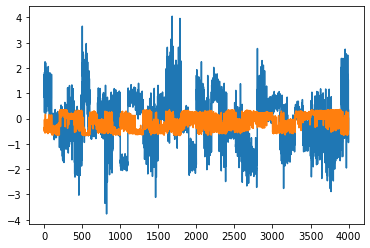

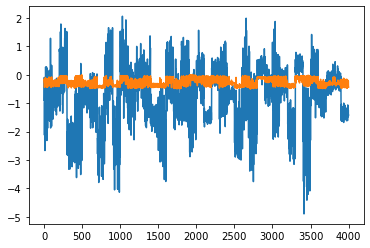

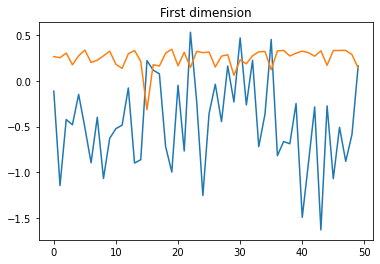

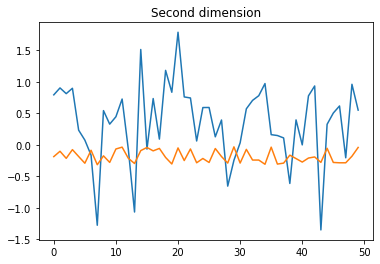

In [37]:
true_y_dim1 = s[:,[0]]
true_y_dim2 = s[:,[1]]
y_dim1 = z_est[:, [0]]
y_dim2 = z_est[:, [1]]


from sklearn.preprocessing import StandardScaler

# Preprocessing
sc_dim1 = StandardScaler()
true_y_dim1 = sc_dim1.fit_transform(true_y_dim1) - true_y_dim1.mean()
y_dim1 = sc_dim1.transform(y_dim1) - y_dim1.mean()

sc_dim2 = StandardScaler()
true_y_dim2 = sc_dim2.fit_transform(true_y_dim2) - true_y_dim2.mean()
y_dim2 = sc_dim2.transform(y_dim2) - y_dim2.mean()



plt.plot(true_y_dim1)
plt.plot(y_dim1)
plt.show()

plt.plot(true_y_dim2)
plt.plot(y_dim2)
plt.show()

plt.plot(true_y_dim1[200:250])
plt.plot(y_dim1[200:250])
plt.title('First dimension')
plt.show()

plt.plot(true_y_dim2[200:250])
plt.plot(y_dim2[200:250])
plt.title('Second dimension')
plt.show()

In [4]:
# Initialize model with correct arguments
# latent_dim = 2
# data_dim = 2
# aux_dim = 5
# n_layers = 3
# activation = 'lrelu'
# device = torch.device('cuda')
# hidden_dim = 50
# anneal = False


# model = iVAE(latent_dim, \
#                  data_dim, \
#                  aux_dim, \
#                  n_layers, \
#                  activation, \
#                  device, \
#                  hidden_dim, \
#                  anneal) # False


# model.load_state_dict(torch.load(PATH))
# model.eval()


NameError: name 'iVAE' is not defined